# GNN模型预测版图寄生电容

## 基本库导入

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf

sys.path.append(os.path.join(os.getcwd(), '..'))

from config import *

# 自定义模块导入
from data.dataset import MyDataset
from models.gcn import GCN
from models.graph_sage import GraphSage
from models.gat import GAT

# fix seed
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## 数据导入与数据分割

In [ ]:
# load data
dataset_total = MyDataset(pattern_nums=pattern_nums,
                          x_name='x_total.npy',
                          y_name='y_total.npy',
                          g_name='total',
                          update=False)
print('load total data done')
dataset_couple = MyDataset(pattern_nums=pattern_nums,
                           x_name='x_couple.npy',
                           y_name='y_couple.npy',
                           g_name='couple',
                           update=False)
print('load couple data done')
print('dataset total', dataset_total)
print('dataset couple', dataset_couple)

# split data # 6:2:2
np.random.shuffle(dataset_total)
np.random.shuffle(dataset_couple)
n = len(dataset_total)
train_data_total, valid_data_total, test_data_total = dataset_total[0:int(n*0.6)], \
                                                        dataset_total[int(n*0.6):int(n*0.8)], \
                                                        dataset_total[int(n*0.8):]
n = len(dataset_couple)
train_data_couple, valid_data_couple, test_data_couple = dataset_couple[0:int(n * 0.6)], \
                                                            dataset_couple[int(n * 0.6):int(n * 0.8)], \
                                                            dataset_couple[int(n * 0.8):]

load total data done
load couple data done
dataset total MyDataset(n_graphs=640)
dataset couple MyDataset(n_graphs=640)


C:\Users\19596\AppData\Local\Temp\ipykernel_2176\3372254273.py:18: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_total)
C:\Users\19596\AppData\Local\Temp\ipykernel_2176\3372254273.py:19: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_couple)


## 模型构建

In [ ]:
from tensorflow.keras.optimizers import Adam
from spektral.data import BatchLoader


# GCN model
if model_name == 'gcn':
	model_total = GCN()
	model_couple = GCN()
elif model_name == 'graph_sage':
	model_total = GraphSage()
	model_couple = GraphSage()
elif model_name == 'gat':
	model_total = GAT()
	model_couple = GAT()
else:
	raise ValueError('model_name error')

model_total.compile(optimizer=Adam(lr=lr),
		            loss='mean_squared_error',
                    weighted_metrics=['MeanSquaredError'])
model_couple.compile(optimizer=Adam(lr=lr),
		            loss='mean_squared_error',
                    weighted_metrics=['MeanSquaredError'])

model_total_save_path = os.path.abspath(os.path.join(os.getcwd(), f'../params/{model_name}_total.h5'))
model_couple_save_path = os.path.abspath(os.path.join(os.getcwd(), f'../params/{model_name}_couple.h5'))

# load model
if os.path.exists(model_total_save_path) and LOAD_PARAMS:
    loader = BatchLoader(train_data_total[:16], batch_size=16, shuffle=False)
    model_total.fit(loader.load(),
                    steps_per_epoch=1,
                    epochs=1)
    try:
        model_total.load_weights(model_total_save_path)
        print('load model total done')
        model_total.summary()
    except:
        print('load model total failed')
if os.path.exists(model_couple_save_path) and LOAD_PARAMS:
    loader = BatchLoader(train_data_couple[:16], batch_size=16, shuffle=False)
    model_couple.fit(loader.load(),
                    steps_per_epoch=1,
                    epochs=1)
    try:
        model_couple.load_weights(model_couple_save_path)
        print('load model couple done')
        model_couple.summary()
    except:
        print('load model couple failed')


c:\360Downloads\conda_pack\envs\tensorflow_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## tensorflow框架设置

### 显存限制

In [ ]:
# 方法一 set memory growth
if SET_MEMORY_GROWTH:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 0:
        try:
            print(gpus[0])
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except RuntimeError as e:
            print(e)

# 方法二 set memory limit
if SET_MEMORY_LIMIT:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 0:
        try:
            print(gpus[0])
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3900)])
        except RuntimeError as e:
            print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical devices cannot be modified after being initialized


### 多卡设置

In [ ]:
import os


if SET_MULTI_GPU:
	os.environ["CUDA_VISIBLE_DEVICES"]="0,1,3,4"

## 集总电容模型

### 集总电容模型训练

Epoch 1/50
24/24 [==============================] - 13s 440ms/step - loss: 148887.7969 - mean_squared_error: 148163.3906 - val_loss: 887.7748 - val_mean_squared_error: 151.2911
Epoch 2/50
24/24 [==============================] - 10s 420ms/step - loss: 3606.7986 - mean_squared_error: 2869.2063 - val_loss: 1447.5970 - val_mean_squared_error: 736.8013
Epoch 3/50
24/24 [==============================] - 10s 421ms/step - loss: 1038.8015 - mean_squared_error: 325.0478 - val_loss: 775.1373 - val_mean_squared_error: 82.4902
Epoch 4/50
24/24 [==============================] - 10s 428ms/step - loss: 723.4204 - mean_squared_error: 25.5612 - val_loss: 686.4230 - val_mean_squared_error: 7.5422
Epoch 5/50
24/24 [==============================] - 11s 445ms/step - loss: 693.0670 - mean_squared_error: 8.8390 - val_loss: 680.7646 - val_mean_squared_error: 14.9352
Epoch 6/50
24/24 [==============================] - 11s 461ms/step - loss: 678.5751 - mean_squared_error: 7.4763 - val_loss: 665.4415 - val_me

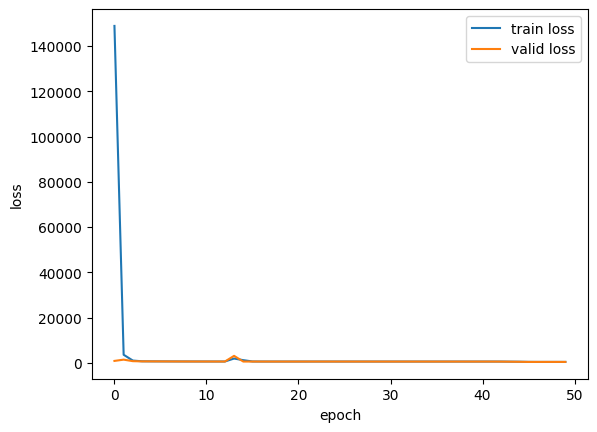

In [ ]:
from spektral.data import BatchLoader


loader_train = BatchLoader(train_data_total, batch_size=16, shuffle=False)
loader_valid = BatchLoader(valid_data_total, batch_size=16, shuffle=False)
model_total.fit(loader_train.load(),
                validation_data=loader_valid.load(),
                steps_per_epoch=loader_train.steps_per_epoch,
                validation_steps=loader_valid.steps_per_epoch,
                epochs=10,
                shuffle=False)
model_total.summary()

# plot 
plt_save_path = os.path.abspath(os.path.join(os.getcwd, f"../results/{model_name}_total_train.jpg"))
history = model_total.history.history
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# save picture and model
if not os.path.exists(plt_save_path):
    os.mkdir(plt_save_path)
plt.savefig(plt_save_path)
model_total.save_weights(model_total_save_path)

### 集总电容模型测试

In [ ]:
from sklearn.metrics import r2_score


def analysis_result(y, y_predict, title):
    relative_error = np.abs(y - y_predict) / y
    max_error = np.max(relative_error)
    mean_error = np.mean(relative_error)
    std_error = np.std(relative_error)
    num_good = np.sum(relative_error <= tolerant_rate) / len(y)
    num_bad = np.sum(relative_error > tolerant_rate) / len(y)
    print(title)
    print('max error:', max_error)
    print('mean error:', mean_error)
    print('std error:', std_error)
    print('good ratio:', num_good)
    print('bad ratio:', num_bad)
    print('')


loader = BatchLoader(test_data_total, batch_size=16)
mse = model_total.evaluate(loader.load(), 
                           steps=loader.steps_per_epoch)
y_predict = model_total.predict(loader.load(), 
                           steps=loader.steps_per_epoch).ravel()
y = np.array([x.y for x in test_data_total])
r2 = r2_score(y, y_predict)
print(f"Test evaluate mse: {mse}")
print(f"Test evaluate r2: {r2}")
analysis_result(y, y_predict, 'total')

c:\360Downloads\conda_pack\envs\tensorflow_gpu\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


8/8 [==============================] - 3s 305ms/step
Test evaluate mse: [451.1731872558594, 23.323732376098633]
Test evaluate r2: -20.588104934392778
total
max error: 1.0091952
mean error: 0.4847884
std error: 0.1600476
good ratio: 0.0078125
bad ratio: 0.9921875



## 耦合电容模型

### 耦合电容模型训练

In [ ]:
from spektral.data import BatchLoader


loader_train = BatchLoader(train_data_total, batch_size=16, shuffle=False)
loader_valid = BatchLoader(valid_data_total, batch_size=16, shuffle=False)
model_couple.fit(loader_train.load(),
                validation_data=loader_valid.load(),
                steps_per_epoch=loader_train.steps_per_epoch,
                validation_steps=loader_valid.steps_per_epoch,
                epochs=10,
                shuffle=False)
model_couple.summary()

# plot 
plt_save_path = os.path.abspath(os.path.join(os.getcwd, f"../results/{model_name}_couple_train.jpg"))
history = model_couple.history.history
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# save picture and model
if not os.path.exists(plt_save_path):
    os.mkdir(plt_save_path)
plt.savefig(plt_save_path)
model_couple.save_weights(model_couple_save_path)

### 耦合电容模型测试

In [ ]:
loader = BatchLoader(test_data_couple, batch_size=16)
mse = model_couple.evaluate(loader.load(), 
                           steps=loader.steps_per_epoch)
y_predict = model_couple.predict(loader.load(), 
                           steps=loader.steps_per_epoch).ravel()
y = np.array([x.y for x in test_data_couple])
r2 = r2_score(y, y_predict)
print(f"Test evaluate mse: {mse}")
print(f"Test evaluate r2: {r2}")
analysis_result(y, y_predict, 'couple')